### 2. Prepare Bigram data for LDA

source: https://www.kaggle.com/jswxhd/risk-factor-mining-cord-19-articles-2021/notebook

In [1]:
import time

In [2]:
start_time = time.time()

import winsound
duration = 1000  # milliseconds
freq = 440  # Hz

In [3]:
import pandas as pd 
import numpy as np
from tqdm import tqdm 
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import collections
import wordcloud
import spacy
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel, Phrases, LdaModel
import time
from lemminflect import getAllInflections


In [4]:

import matplotlib.pyplot as plt
import collections
import wordcloud

In [5]:
data = pd.read_csv('cord19_TitAbsTime_Vaccine.csv')

### Data Preprocessing

In [6]:
data['abstract'] = data['abstract'].apply(lambda x: x.strip().lower())

In [7]:
stopwords = set(stopwords.words('english'))
data['abstract_tokens'] = data['abstract'].apply(lambda x: word_tokenize(x))

In [8]:

## Remove non-English words
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if w.isalpha()])


In [9]:

## Remove Stopwords
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if w not in stopwords])


In [10]:

## Remove words with single characters
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if len(w)>1])
#data['abstract_cleaned'] = data['abstract_tokens'].apply(lambda x: ' '.join(x))


In [11]:
data.head()

,Unnamed: 0,Unnamed: 0.1,title,abstract,publish_time,abstract_tokens
0,0,4242,Dexmedetomidine improved renal function in pat...,background: dexmedetomidine has been reported ...,2020-01-02,"[background, dexmedetomidine, reported, improv..."
1,1,4243,Aortic volume determines global end-diastolic ...,background: global end-diastolic volume (gedv)...,2020-01-02,"[background, global, volume, gedv, measured, t..."
2,2,4244,Whole genome sequencing and phylogenetic analy...,background: human metapneumovirus (hmpv) is an...,2020-01-02,"[background, human, metapneumovirus, hmpv, imp..."
3,3,4245,European intensive care physicians’ experience...,background: antimicrobial resistance (amr) com...,2020-01-02,"[background, antimicrobial, resistance, amr, c..."
4,4,4246,Synthetic carbohydrate-based vaccines: challen...,glycoconjugate vaccines based on bacterial cap...,2020-01-03,"[glycoconjugate, vaccines, based, bacterial, c..."


In [12]:
data.reset_index(drop=True,inplace=True)

In [13]:
inverted_idx = {}
for idx,sentence in enumerate(list(data['abstract_tokens'])):
    for token in set(sentence):
        if token not in inverted_idx:
            inverted_idx[token] = [idx]
        else:
            inverted_idx[token].append(idx)

print(f'There are {len(inverted_idx)} unique words in inverted index')

There are 350312 unique words in inverted index


### Article Matching and Deep Cleaning

In [14]:
keywords_vac = [val[0] for val in getAllInflections('vaccine').values()]
keywords_vac = keywords_vac + [val[0] for val in getAllInflections('vaccinate').values()]
keywords_vac = keywords_vac + [val[0] for val in getAllInflections('vaccination').values()]
keywords_vac = list(set(keywords_vac))
keywords_vac

['vaccinating',
 'vaccinate',
 'vaccine',
 'vaccines',
 'vaccinates',
 'vaccinated',
 'vaccination',
 'vaccinations']

In [15]:
vac_idx = []
for word in keywords_vac:
    try:
        vac_idx += inverted_idx[word]
    except:
        pass
vac_idx = list(set(vac_idx))
print(f'Found {len(vac_idx)} articles related to vaccine')

Found 30208 articles related to vaccine


In [16]:
vac_article = data.iloc[vac_idx,:]
vac_article.head()

,Unnamed: 0,Unnamed: 0.1,title,abstract,publish_time,abstract_tokens
4,4,4246,Synthetic carbohydrate-based vaccines: challen...,glycoconjugate vaccines based on bacterial cap...,2020-01-03,"[glycoconjugate, vaccines, based, bacterial, c..."
393220,483203,736911,Retinal Hemorrhage after SARS-CoV-2 Vaccination,to report retinal vein occlusion (rvo) and age...,2021-12-05,"[report, retinal, vein, occlusion, rvo, macula..."
6,6,4248,Identification of antigens presented by MHC fo...,mycobacterium tuberculosis (m.tb) is responsib...,2020-01-03,"[mycobacterium, tuberculosis, responsible, dea..."
393222,483205,736914,Next-Generation Serology by Mass Spectrometry:...,[image: see text] methods of antibody detectio...,2021-12-08,"[image, see, text, methods, antibody, detectio..."
262152,302536,481315,Pre-vaccination Antibody Titers Against Season...,background the prospective assessment of sars-...,2021,"[background, prospective, assessment, seroconv..."


For topic modeling and visualization, lemmatization is needed. POS tagging technique is also used to filter meaningful words.

In [17]:
def lemmatization(texts, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        ##'-PRON-' is used as the lemma for all pronouns such as their, you, me, and I
        texts_out.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' 
                          for token in doc if token.pos_ in allowed_postags])
    return texts_out 

First, let's see how the word cloud of this corpus looks like.

### how about just focus only on the Nouns
### Not consider verbs like use, study, ...

In [18]:
vac_article['Lemma_Tokens'] = lemmatization(list(vac_article['abstract_tokens']))


<ipython-input-18-5862f1d5be8b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vac_article['Lemma_Tokens'] = lemmatization(list(vac_article['abstract_tokens']))


In [19]:

## convert tokens that frequently occur together as bigram and trigram
bigram = Phrases(list(vac_article['Lemma_Tokens']), min_count=3)
vac_article['Phrase_Lemma_Tokens'] = vac_article['Lemma_Tokens'].apply(lambda x: bigram[x])


<ipython-input-19-bb7a3f715ac6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vac_article['Phrase_Lemma_Tokens'] = vac_article['Lemma_Tokens'].apply(lambda x: bigram[x])


In [20]:
trigram = Phrases(list(vac_article['Phrase_Lemma_Tokens']), min_count=5)
vac_article['Phrase_Lemma_Tokens_trigram'] = vac_article['Phrase_Lemma_Tokens'].apply(lambda x: trigram[x])


<ipython-input-20-abdf61add7e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vac_article['Phrase_Lemma_Tokens_trigram'] = vac_article['Phrase_Lemma_Tokens'].apply(lambda x: trigram[x])


In [21]:
vac_article.to_csv('cord19_vaccine_2020_dataset_withBi-Trigram.csv')

Text(0.5, 1.0, 'Word Cloud: Articles Related to Vaccine')

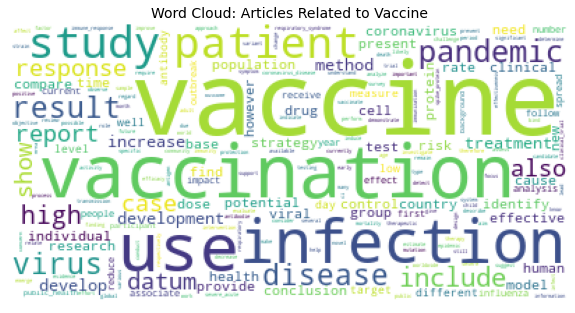

In [22]:
vac_abstract_tokens = []
for tokens in list(vac_article['Phrase_Lemma_Tokens']):
    vac_abstract_tokens += tokens
vac_wordcnt_dict = collections.Counter(vac_abstract_tokens)

wcloud = wordcloud.WordCloud(background_color='white')
wcloud.generate_from_frequencies(vac_wordcnt_dict)
fig,ax = plt.subplots(figsize=(10,8))
ax.imshow(wcloud)
for pos in ['left','right','top','bottom']:
    ax.spines[pos].set_color(None)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Word Cloud: Articles Related to Vaccine' ,fontsize=14)

In [23]:
end_time = time.time()

print('Estimate runtime: ', (end_time-start_time)/60, ' minutes.')

Estimate runtime:  18.845464781920114  minutes.


In [24]:
winsound.Beep(freq, duration)

In [25]:
vac_article.head()

,Unnamed: 0,Unnamed: 0.1,title,abstract,publish_time,abstract_tokens,Lemma_Tokens,Phrase_Lemma_Tokens,Phrase_Lemma_Tokens_trigram
4,4,4246,Synthetic carbohydrate-based vaccines: challen...,glycoconjugate vaccines based on bacterial cap...,2020-01-03,"[glycoconjugate, vaccines, based, bacterial, c...","[glycoconjugate, vaccine, base, bacterial, cap...","[glycoconjugate, vaccine, base, bacterial_caps...","[glycoconjugate, vaccine, base, bacterial_caps..."
393220,483203,736911,Retinal Hemorrhage after SARS-CoV-2 Vaccination,to report retinal vein occlusion (rvo) and age...,2021-12-05,"[report, retinal, vein, occlusion, rvo, macula...","[report, retinal, vein, occlusion, rvo, macula...","[report, retinal_vein, occlusion, rvo, macular...","[report, retinal_vein, occlusion, rvo, macular..."
6,6,4248,Identification of antigens presented by MHC fo...,mycobacterium tuberculosis (m.tb) is responsib...,2020-01-03,"[mycobacterium, tuberculosis, responsible, dea...","[mycobacterium, tuberculosis, responsible, dea...","[mycobacterium_tuberculosis, responsible, deat...","[mycobacterium_tuberculosis, responsible, deat..."
393222,483205,736914,Next-Generation Serology by Mass Spectrometry:...,[image: see text] methods of antibody detectio...,2021-12-08,"[image, see, text, methods, antibody, detectio...","[image, see, text, method, antibody, detection...","[image_see, text, method, antibody, detection,...","[image_see_text, method, antibody, detection, ..."
262152,302536,481315,Pre-vaccination Antibody Titers Against Season...,background the prospective assessment of sars-...,2021,"[background, prospective, assessment, seroconv...","[background, prospective, assessment, seroconv...","[background, prospective, assessment, seroconv...","[background, prospective, assessment, seroconv..."
